### Basic Setup

In [25]:
import os, logging
import numpy as np
import torch as th
from transformations import *
from data import get_datasets
from exploratory_data_analysis import *
import random
from training_testing import *
from models import *
from plotting import *
from utils import *
from sklearn.metrics import RocCurveDisplay

%load_ext autoreload
%autoreload 2

np.random.seed(0)
th.manual_seed(0)
random.seed(0)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('MSP_Project')
logger.setLevel(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Download and Instantiation

In [15]:
in_colab = False
if os.getenv("COLAB_RELEASE_TAG"):
    in_colab = True
    logger.debug("Running in Colab")
train_set, test_set = get_datasets(in_colab, using_mnist=False)

DEBUG:MSP_Project:Data directory: ./full_dataset
DEBUG:MSP_Project:Using mean and std: tensor([0.9961]), tensor([0.0113])
/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
DEBUG:MSP_Project:Class percentages: {'blunt_trauma': 0.5258620689655172, 'firearm': 0.47413793103448276}
DEBUG:MSP_Project:Trying to get a representative test set...
DEBUG:MSP_Project:Class percentages: {'blunt_trauma': 0.4782608695652174, 'firearm': 0.5217391304347826}
DEBUG:MSP_Project:93 images in training set before augmentation.
DEBUG:MSP_Project:372 images in training set.
DEBUG:MSP_Project:23 images in test set.


### Exploratory Data Analysis
Here we are just taking a preliminary look at the data. We show examples of four images from the training set after preprocessing which includes grayscaling and normalizing the pixel intensities.

We also get an idea of the class distribution in the dataset, as well as what the average image per class looks like, to see if there is any qualitatively discernable difference between them.

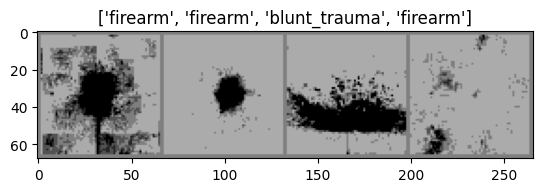

DEBUG:MSP_Project:Dataset classes:['blunt_trauma', 'firearm']
DEBUG:MSP_Project:Class Counts: {'firearm': 172, 'blunt_trauma': 200}


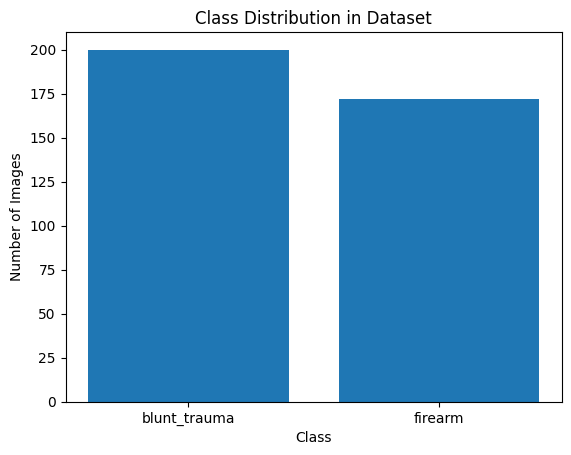

In [16]:
run_eda(train_set)

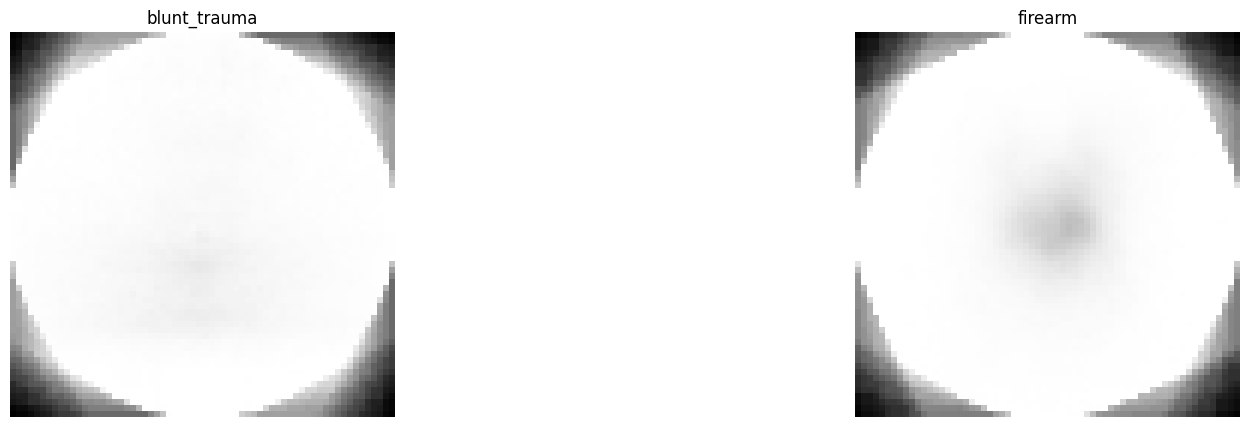

In [17]:
calculate_class_average(train_set)

## Training

### K-Fold Cross Validation
Here we demonstrate running k-fold cross validation, first instantiating a spiking neural network with a beta value of 0.8. This value represents the membrane potential decay rate. We also use an Adam optimizer with a learning rate of 0.001 and a weight decay of 0.0001. These parameters are what we found to yield the highest average accuracy across all 27 hyperparameter configurations that we tried.

We also plot what we call the "smoothed loss", which is calculated by averaging the loss at each epoch over all folds. 

FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 3
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 4
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch

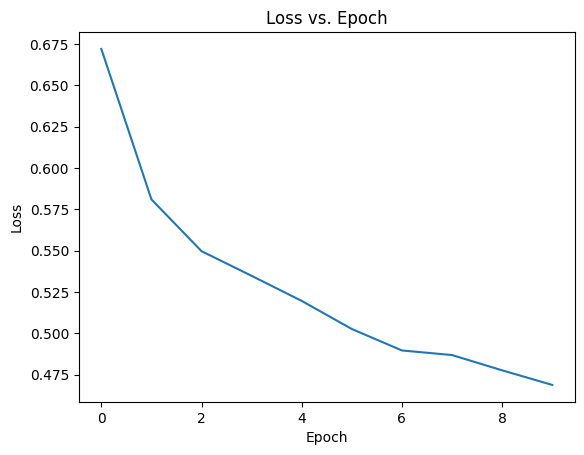

In [11]:
model = SpikingCNN(beta=0.8, num_steps=10, using_mnist=False)
model = model.to(device)
optimizer = th.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
accuracy, loss_record = k_fold_cross_validation(train_set, model, k=10, num_epochs=10, batch_size=32, optimizer=optimizer)
smoothed_loss_record = smooth_k_fold_loss_record(loss_record)
plot_loss(smoothed_loss_record)

### Training a non-spiking convolutional neural network
As a baseline to compare against, we will train a non-spiking CNN that uses ReLU activation. 

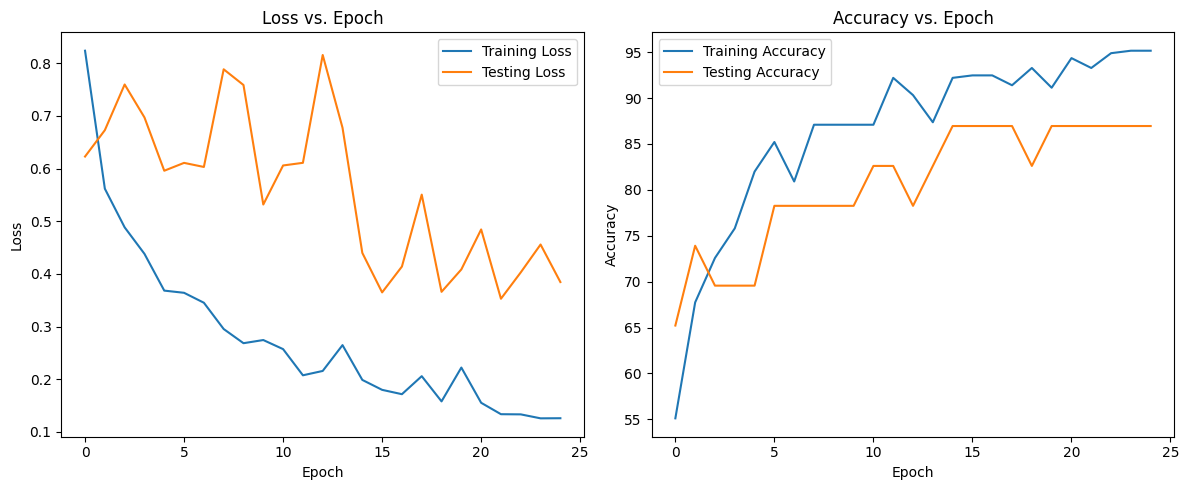

In [22]:
non_spiking_cnn = PyTorchCNN()
non_spiking_cnn = non_spiking_cnn.to(device)
optimizer = th.optim.Adam(non_spiking_cnn.parameters(), lr=0.001, weight_decay=0.001)
training_losses, training_accuracies, testing_losses, testing_accuracies = train_and_test(non_spiking_cnn, optimizer, train_set, test_set, num_epochs=25, batch_size=32)
plot_training_testing_metrics(training_losses, training_accuracies, testing_losses, testing_accuracies)

### Training a spiking convolutional neural network

Epoch 1 loss: 0.67, accuracy: 53.76%
Epoch 1 test loss: 0.60, accuracy: 47.83%
Epoch 2 loss: 0.58, accuracy: 75.81%
Epoch 2 test loss: 0.51, accuracy: 82.61%
Epoch 3 loss: 0.53, accuracy: 80.38%
Epoch 3 test loss: 0.50, accuracy: 86.96%
Epoch 4 loss: 0.51, accuracy: 83.87%
Epoch 4 test loss: 0.57, accuracy: 78.26%
Epoch 5 loss: 0.53, accuracy: 78.76%
Epoch 5 test loss: 0.54, accuracy: 78.26%
Epoch 6 loss: 0.50, accuracy: 84.14%
Epoch 6 test loss: 0.55, accuracy: 82.61%
Epoch 7 loss: 0.51, accuracy: 80.38%
Epoch 7 test loss: 0.49, accuracy: 91.30%
Epoch 8 loss: 0.49, accuracy: 83.87%
Epoch 8 test loss: 0.50, accuracy: 86.96%
Epoch 9 loss: 0.49, accuracy: 83.87%
Epoch 9 test loss: 0.49, accuracy: 86.96%
Epoch 10 loss: 0.48, accuracy: 83.60%
Epoch 10 test loss: 0.49, accuracy: 91.30%
Epoch 11 loss: 0.48, accuracy: 84.41%
Epoch 11 test loss: 0.48, accuracy: 86.96%
Epoch 12 loss: 0.48, accuracy: 85.22%
Epoch 12 test loss: 0.50, accuracy: 82.61%
Epoch 13 loss: 0.47, accuracy: 86.83%
Epoch 13

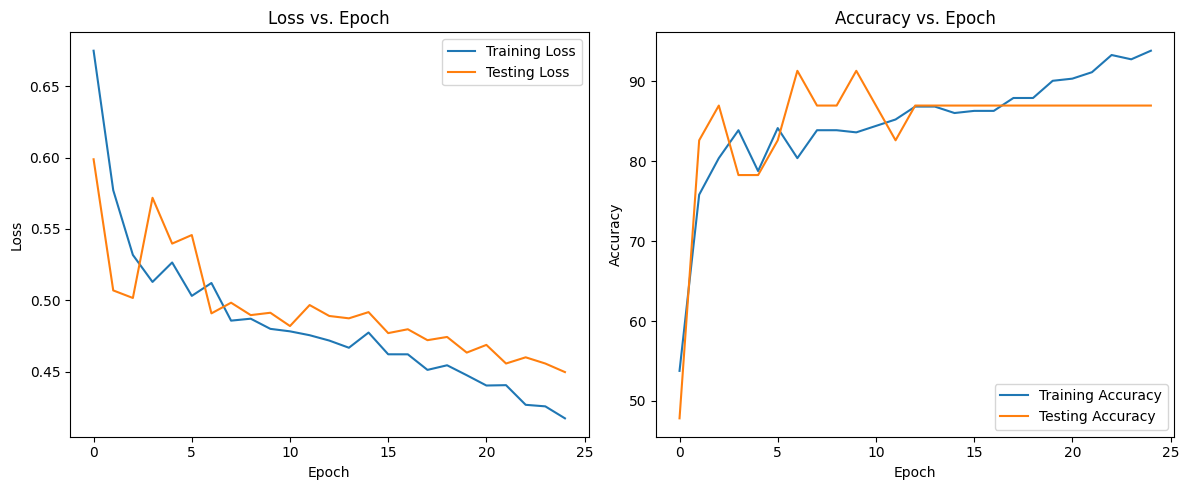

In [20]:
spiking_cnn = SpikingCNNSerial(beta=0.8, num_steps=10)
spiking_cnn = spiking_cnn.to(device)
optimizer = th.optim.Adam(spiking_cnn.parameters(), lr=0.001, weight_decay=0.0001)
training_losses, training_accuracies, testing_losses, testing_accuracies = train_and_test(spiking_cnn, optimizer, train_set, 
                                                                                             test_set, num_epochs=25, batch_size=32, verbose=True)
plot_training_testing_metrics(training_losses, training_accuracies, testing_losses, testing_accuracies)

## Further analysis
### ROC Curve
An additional method of evaluating the classifier is to plot an ROC curve, which illustrates the tradeoff between classifying true positives and false positives when tuning the threshold that determines whether the blood spatter was caused by blunt trauma or not. The ideal balance that the classifier can strike would be a point near the upper left of the graph, and a better classifier would have an ROC curve that gets very close to the upper left corner. 

Unfortunately, because the test set is very sparse (23 images), the curve is very angular and less reliable than what we would be able to see if we had a larger dataset. Nonetheless, it is much better than a random classifier which would have a curve with slope 1 across the diagonal.

In [23]:
fpr, tpr, thresholds, auc_scores = get_roc_metrics(spiking_cnn, test_set, batch_size=32)

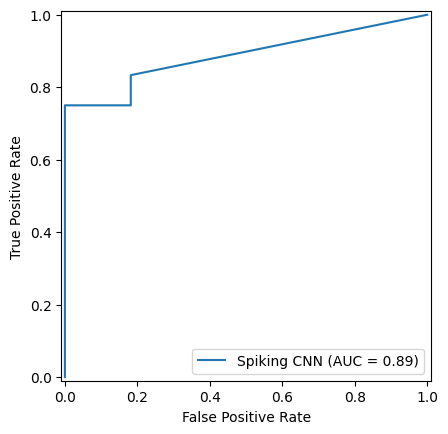

In [24]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_scores, estimator_name='Spiking CNN')
display.plot()

### Plotting of Network Activity
We can now used the trained model to plot what the leaky integrate-and-fire neurons are doing across the ten timesteps that they are receiving information from the upstream convolutional layers. Here we visualize the third and fourth leaky integrate-and-fire layers, which have 120 neurons and 2 neurons respectively. Their membrane potentials over time and their spikes can be shown to be qualitatively different between seeing a blood spatter image caused by blunt trauma vs. seeing a blood spatter image caused by a firearm.

In [26]:
classes = ['Blunt Trauma', 'Firearm']

def plot_for_true_positives(model, test_set):
    plotted_blunt_trauma = False
    plotted_firearm = False
    while not plotted_blunt_trauma:
        for sample_and_label in test_set:
            if sample_and_label[1] == 0:
                sample = sample_and_label[0]
                prediction, spk_rec4, mem_rec4, spk_rec3, mem_rec3 = run_spiking_inference(model, sample)
                if prediction == sample_and_label[1]:
                    plot_network_activity_given_two_lif_activities(spk_rec4, mem_rec4, spk_rec3, mem_rec3, class_name=classes[prediction])
                    plotted_blunt_trauma = True
                    break
    while not plotted_firearm:
        for sample_and_label in test_set:
            if sample_and_label[1] == 1:
                sample = sample_and_label[0]
                prediction, spk_rec4, mem_rec4, spk_rec3, mem_rec3 = run_spiking_inference(model, sample)
                if prediction == sample_and_label[1]:
                    plot_network_activity_given_two_lif_activities(spk_rec4, mem_rec4, spk_rec3, mem_rec3, class_name=classes[prediction])
                    plotted_firearm = True
                    break

def plot_network_activity_given_two_lif_activities(spk_rec4, mem_rec4, spk_rec3, mem_rec3, class_name):
    mem_rec3 = mem_rec3.squeeze(1)
    spk_rec3 = spk_rec3.squeeze(1)
    mem_rec4 = mem_rec4.squeeze(1)
    spk_rec4 = spk_rec4.squeeze(1)
    mem_rec3 = mem_rec3.detach().cpu().numpy().transpose()
    spk_rec3 = spk_rec3.detach().cpu().numpy().transpose()
    mem_rec4 = mem_rec4.detach().cpu().numpy().transpose()
    spk_rec4 = spk_rec4.detach().cpu().numpy().transpose()
    plot_network_activity(mem_rec3, spk_rec3, name=f"Leaky Integrate and Fire Neurons Layer 3 - {class_name}")
    plot_network_activity(mem_rec4, spk_rec4, name=f"Leaky Integrate and Fire Neurons Layer 4 - {class_name}")

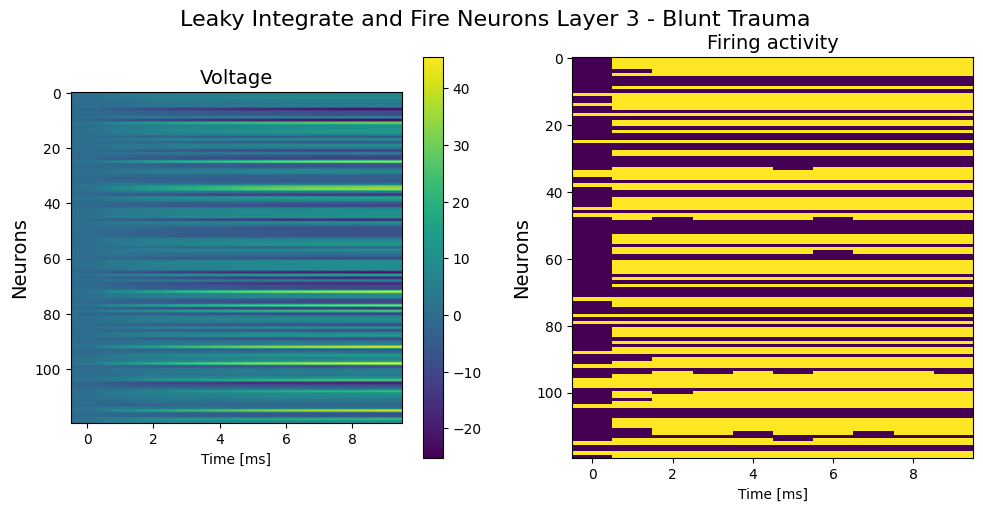

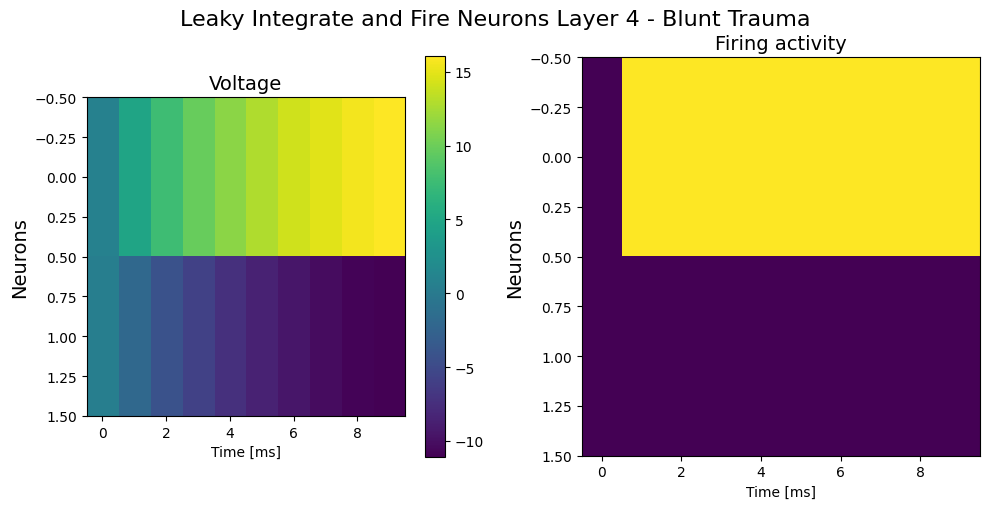

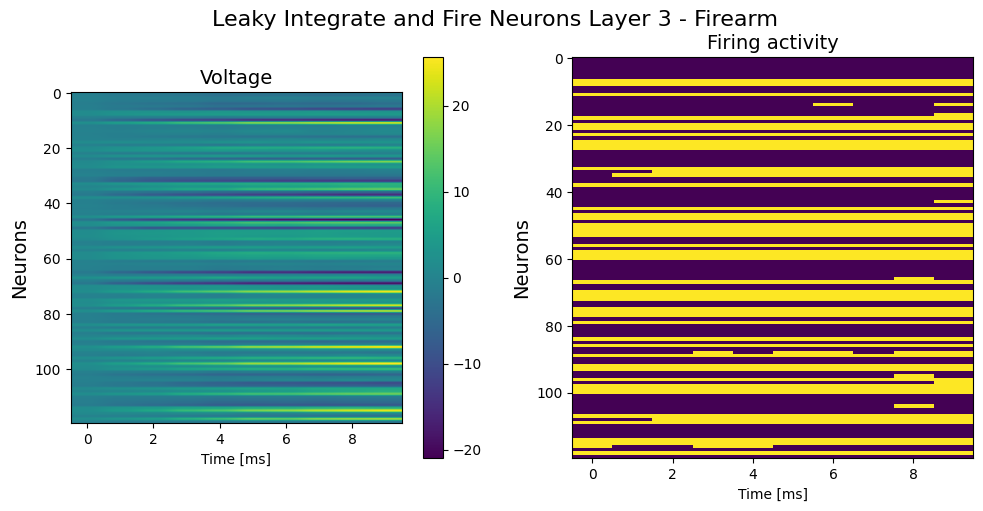

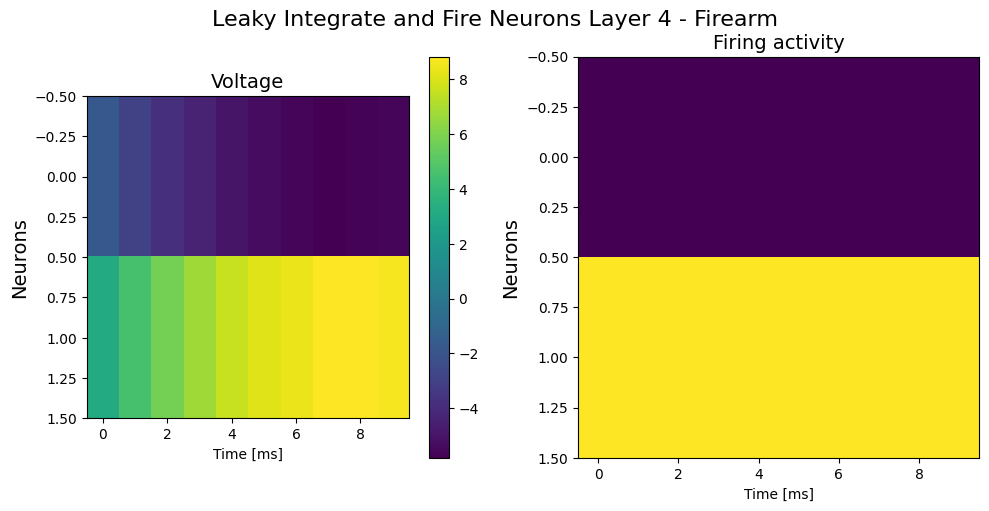

In [27]:
plot_for_true_positives(spiking_cnn, test_set)